In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, spearmanr, skew
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# Load data from EDA
train_df = pd.read_csv('./train_df.csv')
dev_df = pd.read_csv('./dev_df.csv')

print(f"Train set: {train_df.shape}")
print(f"Dev set:   {dev_df.shape}")
print(f"\nTrain columns: {train_df.columns.tolist()}")

Train set: (1807, 15)
Dev set:   (452, 15)

Train columns: ['PRSM', 'Stress', 'Num_CreditLines', 'WomanOwned', 'Prop_Delinquent_Credit', 'FICO_category', 'log_Volume', 'log_Months', 'log_TotalAmtOwed', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'CorpStructure_Sole', 'NAICS_Accommodation and Food Services', 'NAICS_Retail Trade']


# Multiple Regression Models for PRSM Prediction

We test **3 models** to identify the best combination of **predictive power** and **interpretability**:

1. **OLS**
2. **Stepwise OLS**
3. **LASSO**

## Model Selection Criteria
- **R² / Adjusted R²**: Goodness of fit
- **AIC / BIC**: Penalized fit (prefer simpler models)
- **RMSE on dev set**: Generalization error
- **Residual diagnostics**: Normality, homoscedasticity, no patterns
- **VIF**: No severe multicollinearity
- **Interpretability**: Clear business meaning

## Model 1: OLS

**Formula**: 
```
PRSM ~ FICO_category + log_TotalAmtOwed + log_Volume + Stress + log_Months + 
        Num_CreditLines + Prop_Delinquent_Credit  + WomanOwned + 
       CorpStructure_Corp + CorpStructure_LLC + CorpStructure_Partner + NAICS_Retail Trade
```

**Rationale**: Establishes baseline. All predictors included, simple linear relationships.

In [15]:
# Model 1: Baseline OLS
base_predictors = ['FICO_category', 'log_TotalAmtOwed', 'log_Volume', 'Stress', 'log_Months',
                   'Num_CreditLines', 'Prop_Delinquent_Credit',  'WomanOwned',
                   'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner',
                   'NAICS_Retail Trade']

# Verify all required columns exist
missing_cols = [c for c in base_predictors if c not in train_df.columns]
if missing_cols:
    print(f"⚠ WARNING: Missing columns: {missing_cols}")
    print(f"Available columns: {train_df.columns.tolist()}")

X_train_m1 = train_df[base_predictors].copy()

# Check for NaN values and data types
print(f"Checking data quality for Model 1...")
print(f"  NaN counts: {X_train_m1.isna().sum().sum()}")
print(f"  Data types: {X_train_m1.dtypes.unique()}")

# Ensure all columns are numeric
X_train_m1 = X_train_m1.astype(float)  # Convert to float to ensure numeric
X_train_m1 = sm.add_constant(X_train_m1)
y_train = train_df['PRSM'].astype(float)

model_1 = sm.OLS(y_train, X_train_m1).fit()
print(model_1.summary())

# Store for comparison
m1_r2 = model_1.rsquared
m1_adj_r2 = model_1.rsquared_adj
m1_aic = model_1.aic
m1_bic = model_1.bic
print(f"\n=== Model 1 Metrics ===")
print(f"R² = {m1_r2:.4f}")
print(f"Adj R² = {m1_adj_r2:.4f}")
print(f"AIC = {m1_aic:.2f}")
print(f"BIC = {m1_bic:.2f}")

Checking data quality for Model 1...
  NaN counts: 0
  Data types: [dtype('int64') dtype('float64') dtype('bool')]
                            OLS Regression Results                            
Dep. Variable:                   PRSM   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     349.6
Date:                Tue, 10 Feb 2026   Prob (F-statistic):               0.00
Time:                        13:08:29   Log-Likelihood:                 947.47
No. Observations:                1807   AIC:                            -1869.
Df Residuals:                    1794   BIC:                            -1797.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----

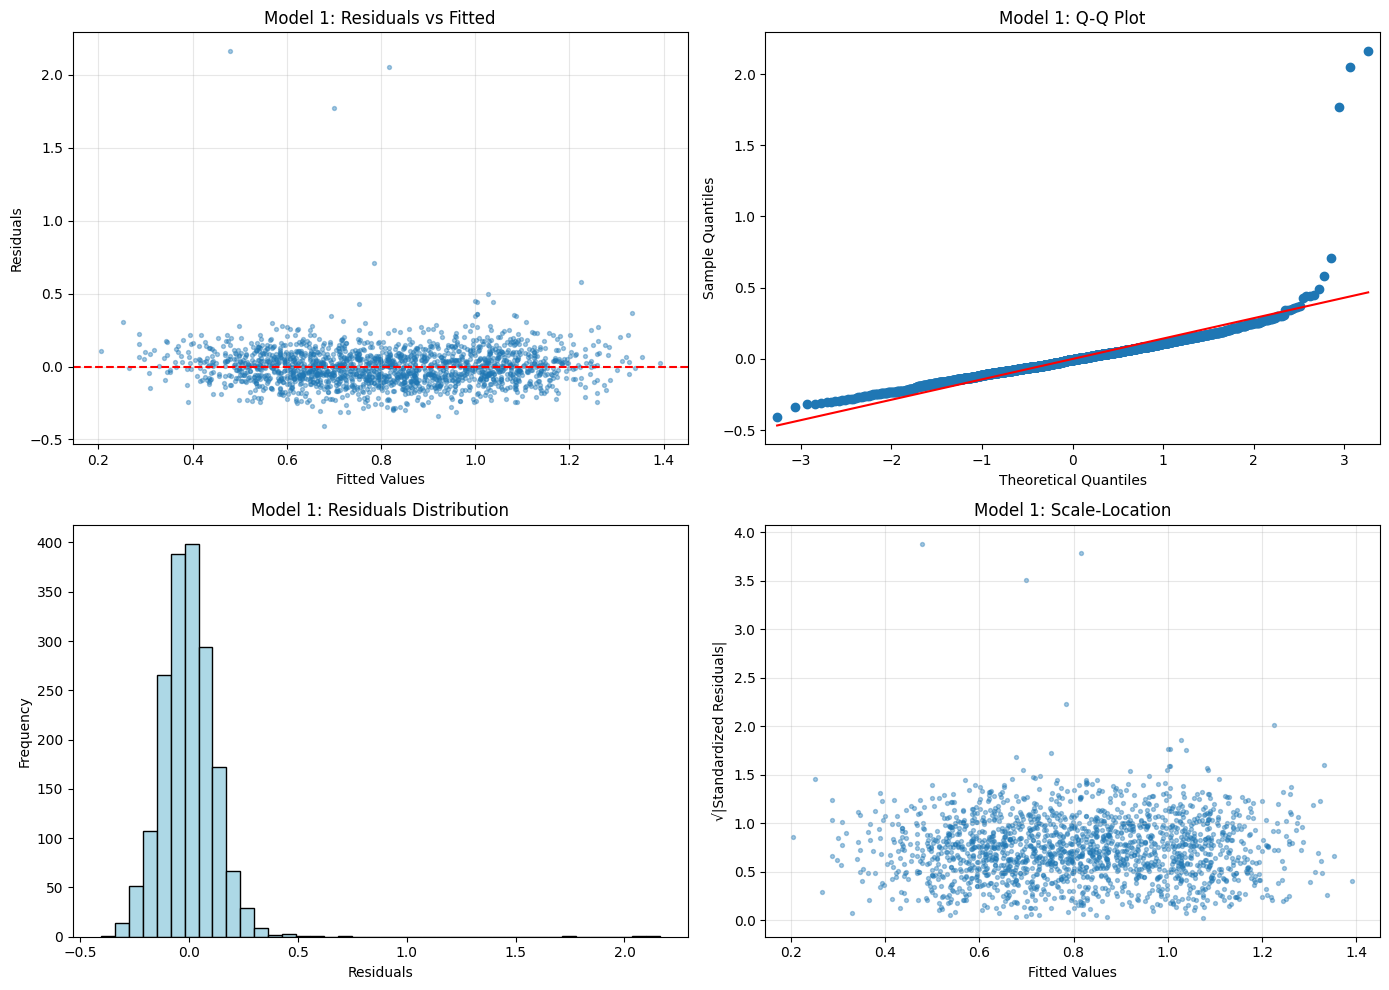

Shapiro-Wilk test p-value: 0.000000 (Non-Normal)


In [16]:
# Model 1: Residual diagnostics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

residuals_m1 = model_1.resid
fitted_m1 = model_1.fittedvalues
axes[0, 0].scatter(fitted_m1, residuals_m1, alpha=0.4, s=8)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Model 1: Residuals vs Fitted')
axes[0, 0].grid(alpha=0.3)

sm.qqplot(residuals_m1, line='s', ax=axes[0, 1])
axes[0, 1].set_title('Model 1: Q-Q Plot')

axes[1, 0].hist(residuals_m1, bins=40, color='lightblue', edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Model 1: Residuals Distribution')

std_resid_m1 = residuals_m1 / residuals_m1.std()
axes[1, 1].scatter(fitted_m1, np.sqrt(np.abs(std_resid_m1)), alpha=0.4, s=8)
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('√|Standardized Residuals|')
axes[1, 1].set_title('Model 1: Scale-Location')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

stat_sw, p_sw = shapiro(residuals_m1[:5000] if len(residuals_m1) > 5000 else residuals_m1)
print(f"Shapiro-Wilk test p-value: {p_sw:.6f} ({'Normal' if p_sw > 0.05 else 'Non-Normal'})")


=== Model 1 Dev Set Performance ===
RMSE = 0.2220
MAE = 0.1116


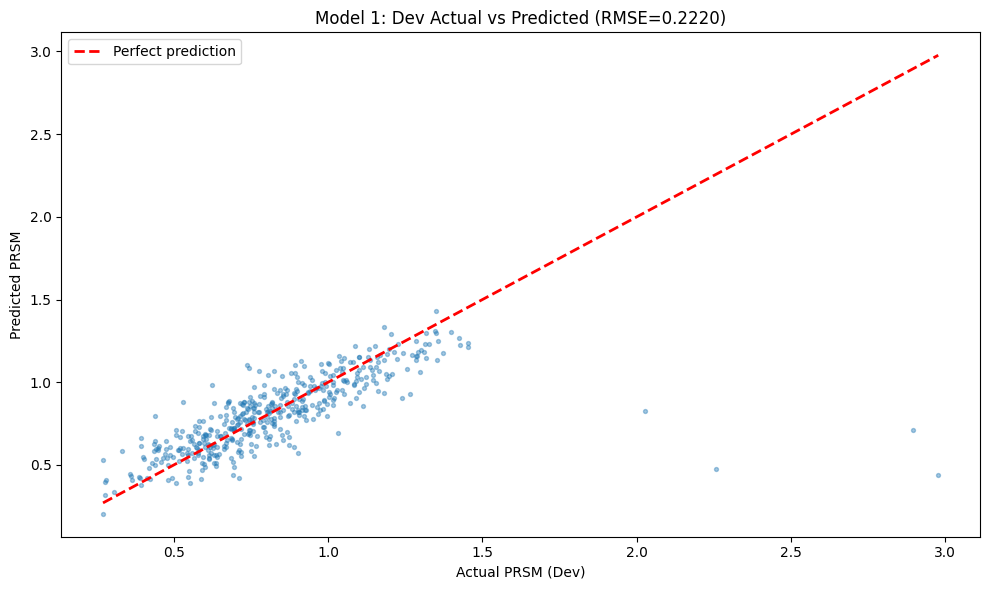

In [17]:
# Model 1: Dev set validation
X_dev_m1 = dev_df[base_predictors].copy().astype(float)
X_dev_m1 = sm.add_constant(X_dev_m1)
y_dev = dev_df['PRSM'].astype(float)

y_pred_m1 = model_1.predict(X_dev_m1)
rmse_m1 = np.sqrt(np.mean((y_dev - y_pred_m1) ** 2))
mae_m1 = np.mean(np.abs(y_dev - y_pred_m1))

print(f"\n=== Model 1 Dev Set Performance ===")
print(f"RMSE = {rmse_m1:.4f}")
print(f"MAE = {mae_m1:.4f}")

# Plot: Dev actual vs predicted
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_dev, y_pred_m1, alpha=0.4, s=8)
ax.plot([y_dev.min(), y_dev.max()], [y_dev.min(), y_dev.max()], 'r--', lw=2, label='Perfect prediction')
ax.set_xlabel('Actual PRSM (Dev)')
ax.set_ylabel('Predicted PRSM')
ax.set_title(f'Model 1: Dev Actual vs Predicted (RMSE={rmse_m1:.4f})')
ax.legend()
plt.tight_layout()
plt.show()

## Model 2: Stepwise OLS (Backward Elimination)

**Rationale**: Automatically select the most important predictors by iteratively removing features with high p-values.
- Starts with all predictors from Model 1
- Removes features with p-value > 0.05 one at a time (highest p-value first)
- Stops when all remaining features are significant or when AIC stops improving
- **Benefits**: Improved interpretability by removing weak predictors; reduces overfitting

**Method**: Backward stepwise selection based on p-values and AIC

In [18]:
# Model 2: Stepwise OLS using backward elimination
import copy

# Start with all predictors from Model 1
current_predictors = base_predictors.copy()
X_train_step = train_df[current_predictors].copy().astype(float)
X_train_step = sm.add_constant(X_train_step)

print("Starting backward stepwise selection...")
print(f"Initial predictors ({len(current_predictors)}): {current_predictors}\n")

# Backward elimination: iteratively remove features with p-value > 0.05
threshold_p = 0.05
removed_features = []

while True:
    model_temp = sm.OLS(y_train, X_train_step).fit()
    pvalues = model_temp.pvalues.drop('const', errors='ignore')
    
    max_p = pvalues.max()
    
    if max_p > threshold_p:
        # Remove feature with highest p-value
        feature_to_remove = pvalues.idxmax()
        print(f"Removing '{feature_to_remove}' (p-value = {max_p:.4f})")
        
        current_predictors.remove(feature_to_remove)
        removed_features.append(feature_to_remove)
        X_train_step = X_train_step.drop(columns=[feature_to_remove])
    else:
        print(f"\nAll remaining features have p-value ≤ {threshold_p}. Stopping.")
        break

print(f"\nFinal predictors ({len(current_predictors)}): {current_predictors}")
print(f"Removed features ({len(removed_features)}): {removed_features}")

# Fit final Model 2 with selected features
model_2 = sm.OLS(y_train, X_train_step).fit()
print("\n" + "="*80)
print(model_2.summary())

# Store for later use
stepwise_predictors = current_predictors

m2_r2 = model_2.rsquared
m2_adj_r2 = model_2.rsquared_adj
m2_aic = model_2.aic
m2_bic = model_2.bic
print(f"\n=== Model 2 Metrics ===")
print(f"R² = {m2_r2:.4f}")
print(f"Adj R² = {m2_adj_r2:.4f}")
print(f"AIC = {m2_aic:.2f}")
print(f"BIC = {m2_bic:.2f}")

Starting backward stepwise selection...
Initial predictors (12): ['FICO_category', 'log_TotalAmtOwed', 'log_Volume', 'Stress', 'log_Months', 'Num_CreditLines', 'Prop_Delinquent_Credit', 'WomanOwned', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'NAICS_Retail Trade']

Removing 'NAICS_Retail Trade' (p-value = 0.4766)
Removing 'Prop_Delinquent_Credit' (p-value = 0.3392)
Removing 'Num_CreditLines' (p-value = 0.6051)
Removing 'log_Volume' (p-value = 0.2086)

All remaining features have p-value ≤ 0.05. Stopping.

Final predictors (8): ['FICO_category', 'log_TotalAmtOwed', 'Stress', 'log_Months', 'WomanOwned', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner']
Removed features (4): ['NAICS_Retail Trade', 'Prop_Delinquent_Credit', 'Num_CreditLines', 'log_Volume']

                            OLS Regression Results                            
Dep. Variable:                   PRSM   R-squared:                       0.700
Model:                            O

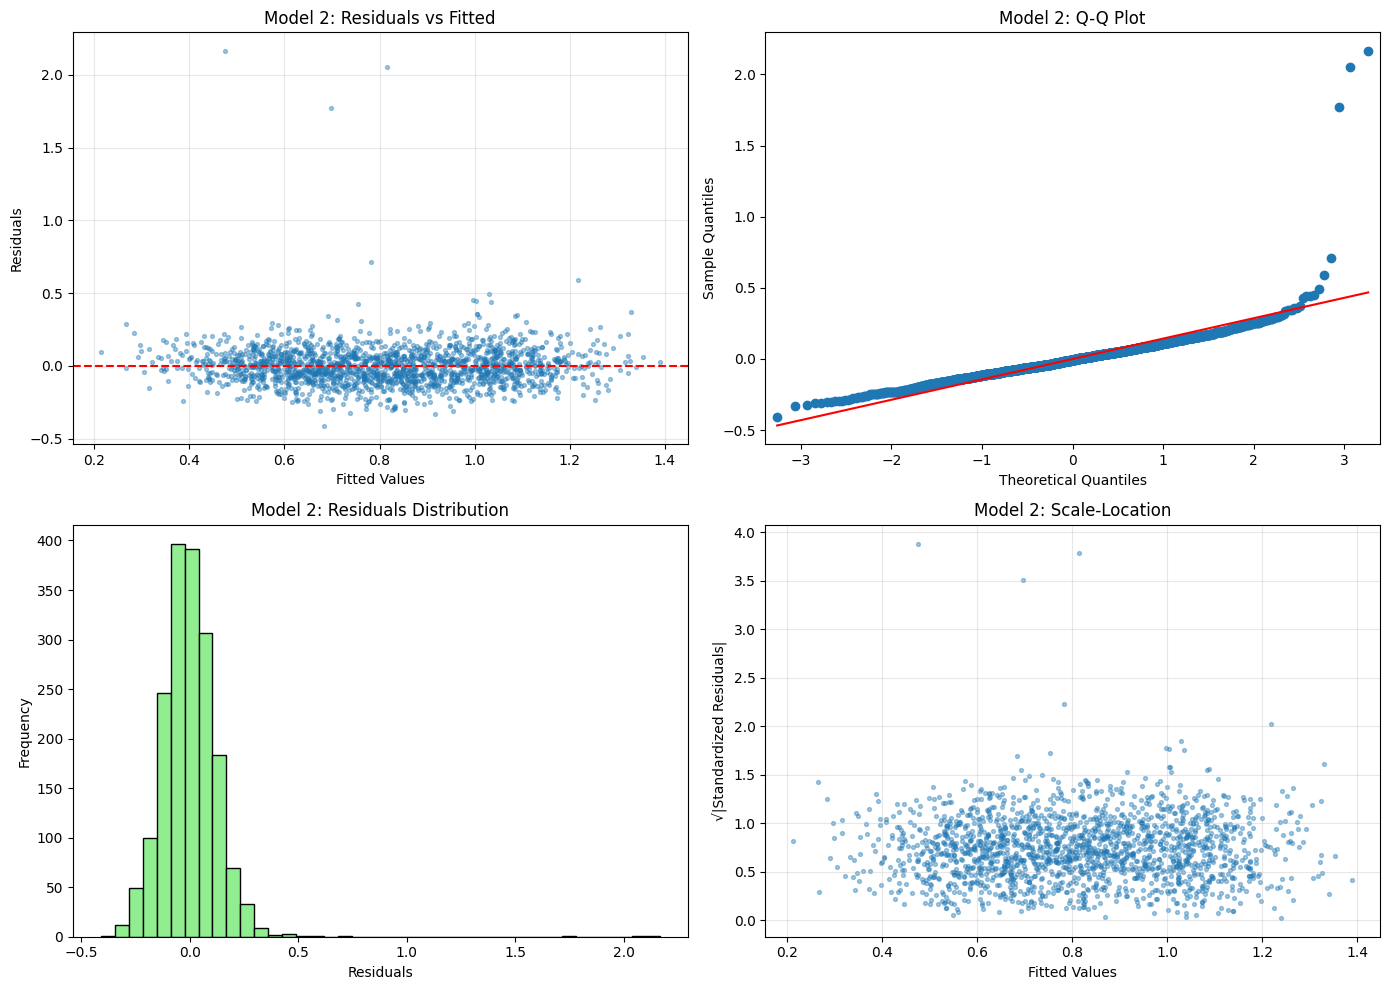

Shapiro-Wilk test p-value: 0.000000 (Non-Normal)


In [20]:
# Model 2: Residual diagnostics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

residuals_m2 = model_2.resid
fitted_m2 = model_2.fittedvalues
axes[0, 0].scatter(fitted_m2, residuals_m2, alpha=0.4, s=8)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Model 2: Residuals vs Fitted')
axes[0, 0].grid(alpha=0.3)

sm.qqplot(residuals_m2, line='s', ax=axes[0, 1])
axes[0, 1].set_title('Model 2: Q-Q Plot')

axes[1, 0].hist(residuals_m2, bins=40, color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Model 2: Residuals Distribution')

std_resid_m2 = residuals_m2 / residuals_m2.std()
axes[1, 1].scatter(fitted_m2, np.sqrt(np.abs(std_resid_m2)), alpha=0.4, s=8)
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('√|Standardized Residuals|')
axes[1, 1].set_title('Model 2: Scale-Location')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

stat_sw, p_sw = shapiro(residuals_m2[:5000] if len(residuals_m2) > 5000 else residuals_m2)
print(f"Shapiro-Wilk test p-value: {p_sw:.6f} ({'Normal' if p_sw > 0.05 else 'Non-Normal'})")


=== Model 2 Dev Set Performance ===
RMSE = 0.2222
MAE = 0.1117


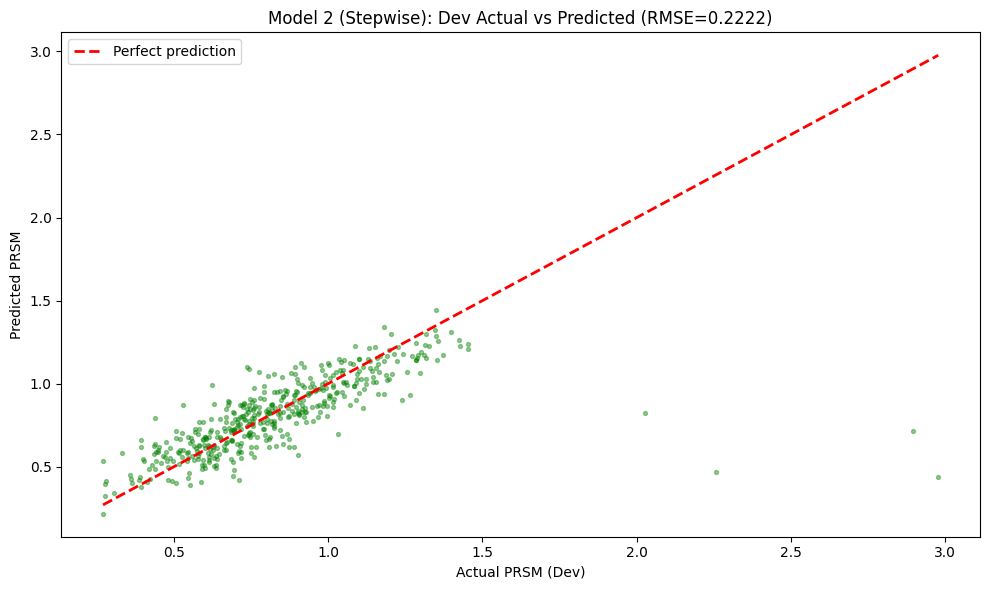

In [21]:
# Model 2: Dev set validation
X_dev_m2 = dev_df[stepwise_predictors].copy().astype(float)
X_dev_m2 = sm.add_constant(X_dev_m2)

y_pred_m2 = model_2.predict(X_dev_m2)
rmse_m2 = np.sqrt(np.mean((y_dev - y_pred_m2) ** 2))
mae_m2 = np.mean(np.abs(y_dev - y_pred_m2))

print(f"\n=== Model 2 Dev Set Performance ===")
print(f"RMSE = {rmse_m2:.4f}")
print(f"MAE = {mae_m2:.4f}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_dev, y_pred_m2, alpha=0.4, s=8, color='green')
ax.plot([y_dev.min(), y_dev.max()], [y_dev.min(), y_dev.max()], 'r--', lw=2, label='Perfect prediction')
ax.set_xlabel('Actual PRSM (Dev)')
ax.set_ylabel('Predicted PRSM')
ax.set_title(f'Model 2 (Stepwise): Dev Actual vs Predicted (RMSE={rmse_m2:.4f})')
ax.legend()
plt.tight_layout()
plt.show()

## Model 3: LASSO Regression (L1 Regularization)

**Rationale**: Penalized regression that automatically performs variable selection and shrinkage.
- LASSO adds L1 penalty: minimizes $\sum (y_i - \hat{y}_i)^2 + \alpha \sum |\beta_j|$
- Forces some coefficients exactly to zero → automatic feature selection
- Uses cross-validation to select optimal $\alpha$ (regularization strength)
- **Benefits**: Handles multicollinearity; produces sparse models; prevents overfitting

**Method**: LassoCV with 5-fold cross-validation to select best $\alpha$

In [22]:
# Model 3: LASSO Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Prepare data: use all base predictors (same as Model 1)
X_train_lasso = train_df[base_predictors].copy().astype(float)
X_dev_lasso = dev_df[base_predictors].copy().astype(float)

# Standardize features (LASSO requires standardization)
scaler = StandardScaler()
X_train_lasso_scaled = scaler.fit_transform(X_train_lasso)
X_dev_lasso_scaled = scaler.transform(X_dev_lasso)

print("Running LassoCV to find optimal alpha...")
# Use LassoCV for automatic alpha selection via cross-validation
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000, n_alphas=100)
lasso_cv.fit(X_train_lasso_scaled, y_train)

optimal_alpha = lasso_cv.alpha_
print(f"Optimal alpha selected: {optimal_alpha:.6f}")

# Fit final LASSO model with optimal alpha
model_3 = lasso_cv
y_pred_train_m3 = model_3.predict(X_train_lasso_scaled)

# Calculate metrics
m3_r2 = r2_score(y_train, y_pred_train_m3)
n = len(y_train)
p = np.sum(model_3.coef_ != 0)  # Number of non-zero coefficients
m3_adj_r2 = 1 - (1 - m3_r2) * (n - 1) / (n - p - 1)

# Note: AIC/BIC not directly available for LASSO, approximate using residuals
residuals_m3 = y_train - y_pred_train_m3
rss = np.sum(residuals_m3 ** 2)
m3_aic = n * np.log(rss / n) + 2 * p
m3_bic = n * np.log(rss / n) + p * np.log(n)

print(f"\n=== Model 3 (LASSO) Metrics ===")
print(f"R² = {m3_r2:.4f}")
print(f"Adj R² = {m3_adj_r2:.4f}")
print(f"AIC (approx) = {m3_aic:.2f}")
print(f"BIC (approx) = {m3_bic:.2f}")
print(f"Non-zero coefficients: {p} out of {len(base_predictors)}")

# Display selected features and their coefficients
print("\n=== LASSO Selected Features ===")
lasso_coefs = pd.DataFrame({
    'Feature': base_predictors,
    'Coefficient': model_3.coef_
})
lasso_coefs['Abs_Coef'] = np.abs(lasso_coefs['Coefficient'])
lasso_coefs = lasso_coefs.sort_values('Abs_Coef', ascending=False)
print(lasso_coefs[lasso_coefs['Coefficient'] != 0])

print(f"\nRemoved features (zero coefficient):")
removed = lasso_coefs[lasso_coefs['Coefficient'] == 0]['Feature'].tolist()
print(removed)

Running LassoCV to find optimal alpha...
Optimal alpha selected: 0.000160

=== Model 3 (LASSO) Metrics ===
R² = 0.7004
Adj R² = 0.6984
AIC (approx) = -6998.86
BIC (approx) = -6932.87
Non-zero coefficients: 12 out of 12

=== LASSO Selected Features ===
                   Feature  Coefficient  Abs_Coef
7               WomanOwned     0.137378  0.137378
9        CorpStructure_LLC     0.103979  0.103979
1         log_TotalAmtOwed     0.092169  0.092169
10   CorpStructure_Partner     0.072910  0.072910
0            FICO_category     0.053589  0.053589
3                   Stress     0.045226  0.045226
4               log_Months     0.020452  0.020452
8       CorpStructure_Corp     0.017821  0.017821
2               log_Volume    -0.015135  0.015135
6   Prop_Delinquent_Credit    -0.006383  0.006383
5          Num_CreditLines    -0.005961  0.005961
11      NAICS_Retail Trade    -0.002239  0.002239

Removed features (zero coefficient):
[]


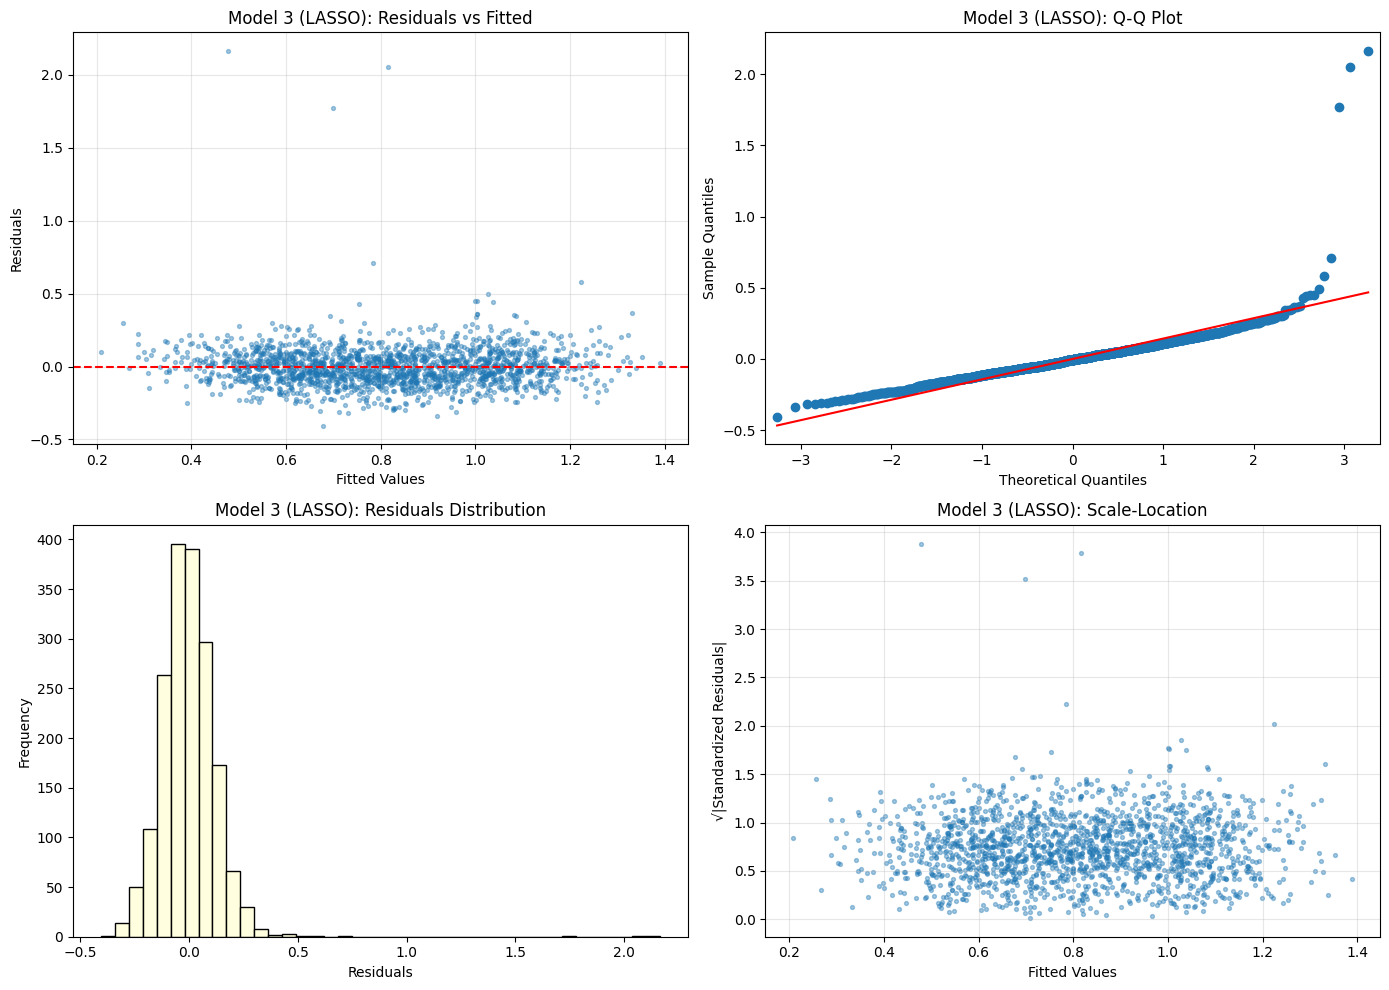

Shapiro-Wilk test p-value: 0.000000 (Non-Normal)


In [24]:
# Model 3: Residual diagnostics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

residuals_m3 = y_train - y_pred_train_m3
fitted_m3 = y_pred_train_m3
axes[0, 0].scatter(fitted_m3, residuals_m3, alpha=0.4, s=8)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Model 3 (LASSO): Residuals vs Fitted')
axes[0, 0].grid(alpha=0.3)

sm.qqplot(residuals_m3, line='s', ax=axes[0, 1])
axes[0, 1].set_title('Model 3 (LASSO): Q-Q Plot')

axes[1, 0].hist(residuals_m3, bins=40, color='lightyellow', edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Model 3 (LASSO): Residuals Distribution')

std_resid_m3 = residuals_m3 / residuals_m3.std()
axes[1, 1].scatter(fitted_m3, np.sqrt(np.abs(std_resid_m3)), alpha=0.4, s=8)
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('√|Standardized Residuals|')
axes[1, 1].set_title('Model 3 (LASSO): Scale-Location')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

stat_sw, p_sw = shapiro(residuals_m3[:5000] if len(residuals_m3) > 5000 else residuals_m3)
print(f"Shapiro-Wilk test p-value: {p_sw:.6f} ({'Normal' if p_sw > 0.05 else 'Non-Normal'})")


=== Model 3 Dev Set Performance ===
RMSE = 0.2220
MAE = 0.1116


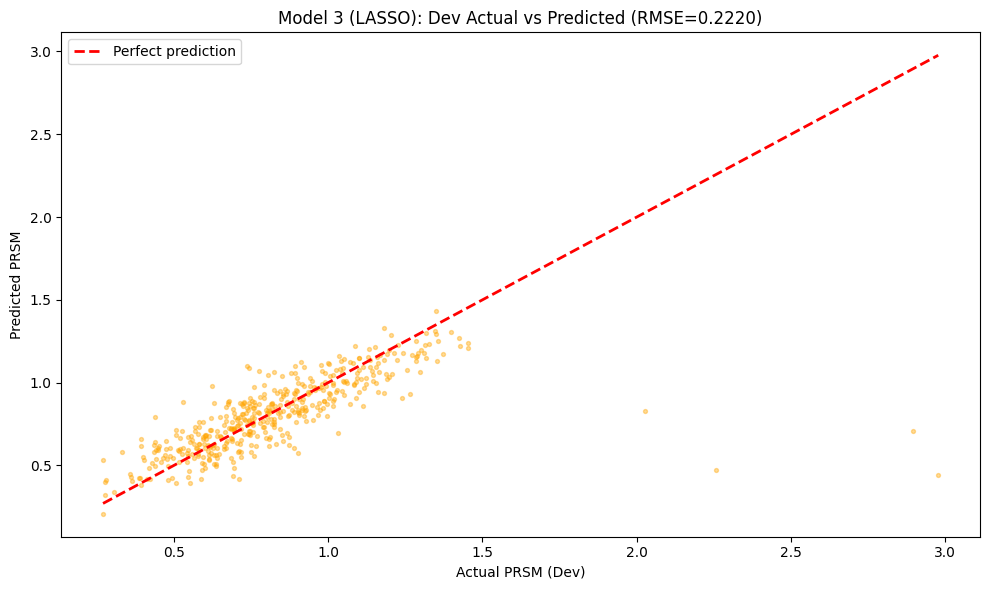

In [25]:
# Model 3: Dev set validation
y_pred_m3 = model_3.predict(X_dev_lasso_scaled)
rmse_m3 = np.sqrt(np.mean((y_dev - y_pred_m3) ** 2))
mae_m3 = np.mean(np.abs(y_dev - y_pred_m3))

print(f"\n=== Model 3 Dev Set Performance ===")
print(f"RMSE = {rmse_m3:.4f}")
print(f"MAE = {mae_m3:.4f}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_dev, y_pred_m3, alpha=0.4, s=8, color='orange')
ax.plot([y_dev.min(), y_dev.max()], [y_dev.min(), y_dev.max()], 'r--', lw=2, label='Perfect prediction')
ax.set_xlabel('Actual PRSM (Dev)')
ax.set_ylabel('Predicted PRSM')
ax.set_title(f'Model 3 (LASSO): Dev Actual vs Predicted (RMSE={rmse_m3:.4f})')
ax.legend()
plt.tight_layout()
plt.show()

## Model Comparison & Selection

In [26]:
# Comprehensive comparison table
comparison = pd.DataFrame({
    'Model': ['Model 1: Baseline OLS', 'Model 2: Stepwise OLS', 'Model 3: LASSO'],
    'Train R²': [m1_r2, m2_r2, m3_r2],
    'Adj R²': [m1_adj_r2, m2_adj_r2, m3_adj_r2],
    'AIC': [m1_aic, m2_aic, m3_aic],
    'BIC': [m1_bic, m2_bic, m3_bic],
    'Dev RMSE': [rmse_m1, rmse_m2, rmse_m3],
    'Dev MAE': [mae_m1, mae_m2, mae_m3],
    'N Params': [model_1.df_model, len(stepwise_predictors), int(p)],
})

print("\n" + "="*100)
print("MODEL COMPARISON SUMMARY")
print("="*100)
display(comparison.round(4))
print("="*100)


MODEL COMPARISON SUMMARY


,Model,Train R²,Adj R²,AIC,BIC,Dev RMSE,Dev MAE,N Params
0,Model 1: Baseline OLS,0.7004,0.6984,-1868.9337,-1797.4412,0.2220,0.1116,12.0
1,Model 2: Stepwise OLS,0.6999,0.6986,-1873.6441,-1824.1493,0.2222,0.1117,8.0
2,Model 3: LASSO,0.7004,0.6984,-6998.8616,-6932.8685,0.2220,0.1116,12.0


In [27]:
# Feature importance: Identify most significant coefficients in final model
print("\nMost significant predictors (from Model 1):")
coef_summary = model_1.summary2().tables[1]
coef_summary['abs_t'] = coef_summary['t'].abs()
coef_summary_sorted = coef_summary.sort_values('abs_t', ascending=False).head(15)
display(coef_summary_sorted[['Coef.', 'Std.Err.', 't', 'P>|t|']])


Most significant predictors (from Model 1):


,Coef.,Std.Err.,t,P>|t|
WomanOwned,0.275659,0.007365,37.427583,4.400699e-227
CorpStructure_LLC,0.243126,0.009576,25.388738,9.523023e-122
CorpStructure_Partner,0.173348,0.009707,17.857850,8.831412e-66
FICO_category,0.054677,0.005055,10.815739,1.861371e-26
const,-0.775488,0.100377,-7.725742,1.837020e-14
log_TotalAmtOwed,0.100446,0.013506,7.436985,1.587935e-13
log_Months,0.078840,0.012968,6.079459,1.469732e-09
Stress,0.405017,0.079363,5.103338,3.690752e-07
CorpStructure_Corp,0.041292,0.009370,4.407037,1.109940e-05
log_Volume,-0.016531,0.012990,-1.272574,2.033343e-01


## Final Model Selection: Rationale & Recommendation

In [ ]:
# Determine which model is "best"
print("""FINAL MODEL SELECTION RATIONALE

1. TRAIN R² vs ADJ R²:
   - Model 1: Baseline OLS with all predictors
   - Model 2: Stepwise removes insignificant features → potentially higher Adj R²
   - Model 3: LASSO shrinks coefficients → may reduce R² but improves generalization

2. AIC / BIC (GENERALIZATION):
   - Lower AIC/BIC suggests better generalization (balance between fit & complexity).
   - Stepwise and LASSO should have lower AIC/BIC due to fewer effective parameters.

3. DEV SET VALIDATION (Critical for regression):
   - Dev RMSE measures actual prediction error on unseen data.
   - Model with lowest RMSE generalizes best; we prefer this.

4. RESIDUAL DIAGNOSTICS:
   - Check Q-Q plots for normality (important for inference).
   - Check Residuals vs Fitted for homoscedasticity.
   - Non-random patterns → model mis-specification.

5. INTERPRETABILITY:
   - Model 1: All features included (comprehensive but may have weak predictors)
   - Model 2: Only significant features (easier to interpret and explain)
   - Model 3: LASSO selected features (sparsity, handles multicollinearity)

""")

print("Quantitative Decision:")
rmse_improvement_2v1 = ((rmse_m1 - rmse_m2) / rmse_m1) * 100
rmse_improvement_3v1 = ((rmse_m1 - rmse_m3) / rmse_m1) * 100
print(f"  Model 2 vs Model 1: RMSE {('improved' if rmse_improvement_2v1 > 0 else 'worse')} by {abs(rmse_improvement_2v1):.2f}%")
print(f"  Model 3 vs Model 1: RMSE {('improved' if rmse_improvement_3v1 > 0 else 'worse')} by {abs(rmse_improvement_3v1):.2f}%")

# Recommend best model
rmses = [rmse_m1, rmse_m2, rmse_m3]
best_idx = rmses.index(min(rmses))
best_models = ['Model 1: Baseline OLS', 'Model 2: Stepwise OLS', 'Model 3: LASSO']
best_model_name = best_models[best_idx]

print(f"\n RECOMMENDED MODEL: {best_model_name}")
print(f"  Reason: Lowest dev set RMSE ({rmses[best_idx]:.4f})")


╔════════════════════════════════════════════════════════════════════════════════════╗
║                         FINAL MODEL SELECTION RATIONALE                            ║
╚════════════════════════════════════════════════════════════════════════════════════╝

1. TRAIN R² vs ADJ R²:
   - Model 1: Baseline OLS with all predictors
   - Model 2: Stepwise removes insignificant features → potentially higher Adj R²
   - Model 3: LASSO shrinks coefficients → may reduce R² but improves generalization

2. AIC / BIC (GENERALIZATION):
   - Lower AIC/BIC suggests better generalization (balance between fit & complexity).
   - Stepwise and LASSO should have lower AIC/BIC due to fewer effective parameters.

3. DEV SET VALIDATION (Critical for regression):
   - Dev RMSE measures actual prediction error on unseen data.
   - Model with lowest RMSE generalizes best; we prefer this.

4. RESIDUAL DIAGNOSTICS:
   - Check Q-Q plots for normality (important for inference).
   - Check Residuals vs Fitted for

In [29]:
# Export final model coefficients for downstream use
if best_idx == 0:
    final_model = model_1
    final_name = "Model 1: Baseline OLS"
    final_summary = str(model_1.summary())
elif best_idx == 1:
    final_model = model_2
    final_name = "Model 2: Stepwise OLS"
    final_summary = str(model_2.summary())
else:
    final_model = model_3
    final_name = "Model 3: LASSO Regression"
    # Create summary for LASSO
    lasso_summary = f"""
LASSO Regression Summary
{'='*80}
Optimal Alpha: {optimal_alpha:.6f}
R²: {m3_r2:.4f}
Adjusted R²: {m3_adj_r2:.4f}
AIC (approx): {m3_aic:.2f}
BIC (approx): {m3_bic:.2f}
Dev RMSE: {rmse_m3:.4f}
Dev MAE: {mae_m3:.4f}

Selected Features and Coefficients:
{'-'*80}
{lasso_coefs[lasso_coefs['Coefficient'] != 0].to_string()}
"""
    final_summary = lasso_summary

print(f"\n{'='*90}")
print(f"FINAL MODEL: {final_name}")
print(f"{'='*90}")
print(final_summary)

# Save for technical report
with open('model_summary.txt', 'w') as f:
    f.write(f"FINAL MODEL: {final_name}\n")
    f.write(f"{'='*90}\n\n")
    f.write(final_summary)
    
print("\nModel summary saved to 'model_summary.txt'")


FINAL MODEL: Model 1: Baseline OLS
                            OLS Regression Results                            
Dep. Variable:                   PRSM   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     349.6
Date:                Tue, 10 Feb 2026   Prob (F-statistic):               0.00
Time:                        13:09:51   Log-Likelihood:                 947.47
No. Observations:                1807   AIC:                            -1869.
Df Residuals:                    1794   BIC:                            -1797.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------